In [1]:
pip install stable-baselines3 gym numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.3 MB/s eta 0:00:00


In [5]:
pip install shimmy

In [14]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import Image, display
from matplotlib.patches import Rectangle
from IPython.display import clear_output
import os
import time

class WarehouseEnv(gym.Env):
    """Custom Environment with graphical visualization using Matplotlib."""
    metadata = {'render.modes': ['human']}

    def __init__(self, rows, cols, obstacles, start_pos, goal_pos):
        super(WarehouseEnv, self).__init__()
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols))  # Empty grid initialized
        self.obstacles = obstacles
        self.start_pos = start_pos
        self.goal_pos = goal_pos
        self.current_pos = start_pos

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(self.rows, self.cols), shape=(2,), dtype=np.int32)

        # Mark obstacles on the grid
        for (x, y) in obstacles:
            self.grid[x][y] = -1  # Obstacle marked as -1

        # Create a figure and axis for rendering
        self.fig, self.ax = plt.subplots()

    def reset(self):
        """ Reset the environment to the initial state """
        self.current_pos = self.start_pos
        return np.array(self.current_pos)

    def step(self, action):
        """ Execute one time step in the environment """
        x, y = self.current_pos

        if action == 0:  # Forward
            new_pos = (x-1, y)
        elif action == 1:  # Reverse
            new_pos = (x+1, y)
        elif action == 2:  # Left
            new_pos = (x, y-1)
        elif action == 3:  # Right
            new_pos = (x, y+1)
        elif action == 4:  # Wait
            new_pos = (x, y)  # No movement

        # Ensure the move is valid
        if self.is_valid_position(new_pos):
            self.current_pos = new_pos

        # Calculate reward
        reward = self.get_reward()

        # Check if episode is done
        done = bool(self.current_pos == self.goal_pos)

        return np.array(self.current_pos), reward, done, {}

    def is_valid_position(self, pos):
        """ Check if a position is within the grid and not an obstacle """
        x, y = pos
        return 0 <= x < self.rows and 0 <= y < self.cols and self.grid[x][y] == 0

    def get_reward(self):
        """ Get the reward for the current position """
        if self.current_pos == self.goal_pos:
            return 100  # Reached destination
        elif self.current_pos in self.obstacles:
            return -10  # Hit an obstacle
        else:
            return -1  # Time penalty

    def render(self, mode='human'):
        """ Render the environment in Colab using Matplotlib and IPython display """
        # Clear the previous output
        clear_output(wait=True)

        # Create the figure and axes
        fig, ax = plt.subplots(figsize=(5, 5))

        # Draw grid and obstacles
        for x in range(self.rows):
            for y in range(self.cols):
                ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='gray'))

        # Draw obstacles
        for (x, y) in self.obstacles:
            ax.add_patch(Rectangle((y, x), 1, 1, color='black'))

        # Draw goal
        goal_x, goal_y = self.goal_pos
        ax.add_patch(Rectangle((goal_y, goal_x), 1, 1, color='green'))

        # Draw bot
        bot_x, bot_y = self.current_pos
        ax.add_patch(Rectangle((bot_y, bot_x), 1, 1, color='blue'))

        # Set axis limits and labels
        ax.set_xlim([0, self.cols])
        ax.set_ylim([0, self.rows])
        ax.set_xticks(np.arange(0, self.cols, 1))
        ax.set_yticks(np.arange(0, self.rows, 1))
        ax.grid(True)
        ax.set_title(f"Bot position: {self.current_pos}, Goal: {self.goal_pos}")

        # Show the plot
        plt.show()
        time.sleep(0.1)  # Pause for a moment to allow visualization

    def close(self):
        plt.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


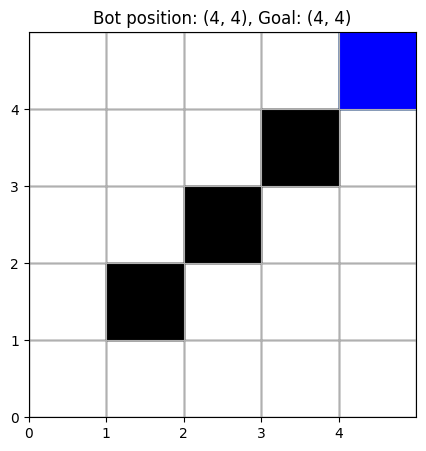

Goal reached!


In [15]:
from stable_baselines3 import PPO

# Initialize the environment
obstacles = [(1, 1), (2, 2), (3, 3)]
env = WarehouseEnv(rows=5, cols=5, obstacles=obstacles, start_pos=(0, 0), goal_pos=(4, 4))

# Train using PPO algorithm
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("ppo_warehouse_agent")

# Test the trained model and render the environment
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()  # Render the environment with Matplotlib visualization
    if done:
        print("Goal reached!")
        break

env.close()  # Close the visualization window


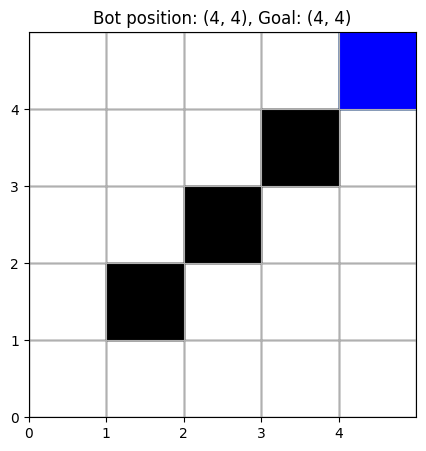

Goal reached!


In [16]:
# Load the trained model
model = PPO.load("ppo_warehouse_agent")

# Reset the environment
obs = env.reset()

for i in range(100):  # Run for 100 steps or until done
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()  # Visualize each step
    if done:
        print("Goal reached!")
        break

In [17]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output
import random
import time

class WarehouseEnv(gym.Env):
    """Custom Environment that dynamically adjusts objects in the grid."""
    metadata = {'render.modes': ['human']}

    def __init__(self, rows, cols, num_obstacles, start_pos=None, goal_pos=None):
        super(WarehouseEnv, self).__init__()
        self.rows = rows
        self.cols = cols
        self.num_obstacles = num_obstacles
        self.obstacles = []  # Obstacles will be placed dynamically
        self.start_pos = start_pos
        self.goal_pos = goal_pos
        self.current_pos = start_pos

        # Define action and observation space
        self.action_space = spaces.Discrete(5)  # 5 possible actions (Forward, Reverse, Left, Right, Wait)
        self.observation_space = spaces.Box(low=0, high=max(self.rows, self.cols), shape=(2,), dtype=np.int32)

        # Create a grid where obstacles will be placed later
        self.grid = np.zeros((rows, cols))  # Empty grid initialized

    def reset(self):
        """ Reset the environment by dynamically placing objects. """
        # Clear the grid
        self.grid = np.zeros((self.rows, self.cols))

        # Randomly place the start position, goal position, and obstacles
        self._place_dynamic_objects()

        # Set the bot's initial position
        self.current_pos = self.start_pos
        return np.array(self.current_pos)

    def _place_dynamic_objects(self):
        """ Dynamically place the start position, goal, and obstacles. """
        # Clear any previous obstacles
        self.obstacles.clear()

        # Get all possible positions on the grid
        all_positions = [(x, y) for x in range(self.rows) for y in range(self.cols)]

        # Randomly pick a start position
        self.start_pos = random.choice(all_positions)
        all_positions.remove(self.start_pos)

        # Randomly pick a goal position, making sure it's different from the start
        self.goal_pos = random.choice(all_positions)
        all_positions.remove(self.goal_pos)

        # Randomly place obstacles, avoiding the start and goal positions
        for _ in range(self.num_obstacles):
            obstacle_pos = random.choice(all_positions)
            self.obstacles.append(obstacle_pos)
            all_positions.remove(obstacle_pos)

        # Mark obstacles on the grid
        for (x, y) in self.obstacles:
            self.grid[x][y] = -1  # Mark obstacle positions as -1

    def step(self, action):
        """ Execute one time step in the environment """
        x, y = self.current_pos

        if action == 0:  # Forward
            new_pos = (x-1, y)
        elif action == 1:  # Reverse
            new_pos = (x+1, y)
        elif action == 2:  # Left
            new_pos = (x, y-1)
        elif action == 3:  # Right
            new_pos = (x, y+1)
        elif action == 4:  # Wait
            new_pos = (x, y)  # No movement

        # Ensure the move is valid
        if self.is_valid_position(new_pos):
            self.current_pos = new_pos

        # Calculate reward
        reward = self.get_reward()

        # Check if episode is done
        done = bool(self.current_pos == self.goal_pos)

        return np.array(self.current_pos), reward, done, {}

    def is_valid_position(self, pos):
        """ Check if a position is within the grid and not an obstacle """
        x, y = pos
        return 0 <= x < self.rows and 0 <= y < self.cols and self.grid[x][y] == 0

    def get_reward(self):
        """ Get the reward for the current position """
        if self.current_pos == self.goal_pos:
            return 100  # Reached destination
        elif self.current_pos in self.obstacles:
            return -10  # Hit an obstacle
        else:
            return -1  # Time penalty

    def render(self, mode='human'):
        """ Render the environment in Colab using Matplotlib and IPython display """
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5, 5))

        # Draw grid and obstacles
        for x in range(self.rows):
            for y in range(self.cols):
                ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='gray'))

        # Draw obstacles
        for (x, y) in self.obstacles:
            ax.add_patch(Rectangle((y, x), 1, 1, color='black'))

        # Draw goal
        goal_x, goal_y = self.goal_pos
        ax.add_patch(Rectangle((goal_y, goal_x), 1, 1, color='green'))

        # Draw bot
        bot_x, bot_y = self.current_pos
        ax.add_patch(Rectangle((bot_y, bot_x), 1, 1, color='blue'))

        ax.set_xlim([0, self.cols])
        ax.set_ylim([0, self.rows])
        ax.set_xticks(np.arange(0, self.cols, 1))
        ax.set_yticks(np.arange(0, self.rows, 1))
        ax.grid(True)
        ax.set_title(f"Bot position: {self.current_pos}, Goal: {self.goal_pos}")

        plt.show()
        time.sleep(0.1)

    def close(self):
        plt.close()


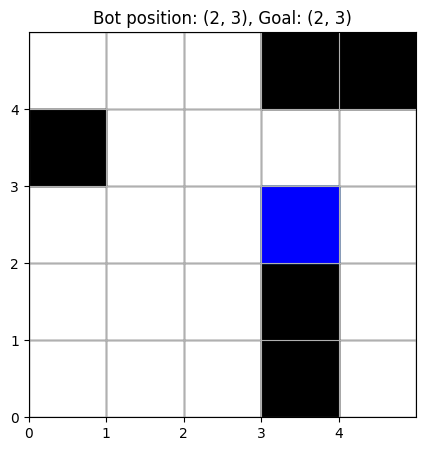

Goal reached!


In [38]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
import os

# Initialize the environment
env = WarehouseEnv(rows=5, cols=5, num_obstacles=5)

# Create the directory to save models
checkpoint_dir = '/content/models2'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the checkpoint callback to save models every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=checkpoint_dir, name_prefix='ppo_warehouse')

# Initialize the PPO model
log_dir = "ppotest_lunarlander_tensorboard/"
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log = log_dir)
# Train the model and save checkpoints dynamically
model.learn(total_timesteps=10000, callback=checkpoint_callback)

obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()  # Render the environment with dynamic objects
    if done:
        print("Goal reached!")
        break

env.close()  # Close the visualization window


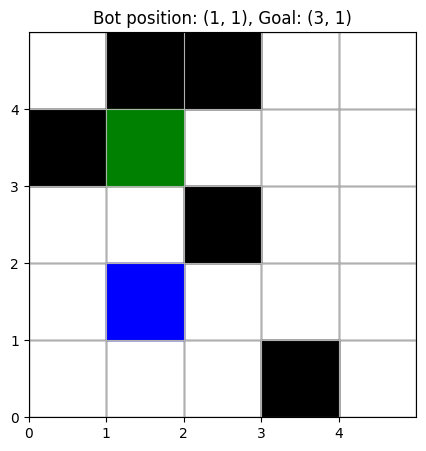

-1


In [33]:
obs = env.reset()
for i in range(100):
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()  # Render the environment with dynamic objects
    if done:
        print("Goal reached!")
        break

env.close()  # Close the visualization window
print(reward)

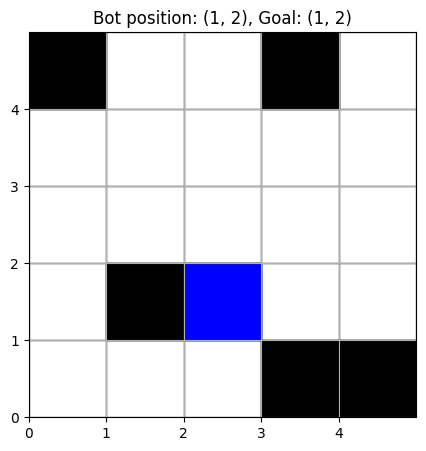

Goal reached!


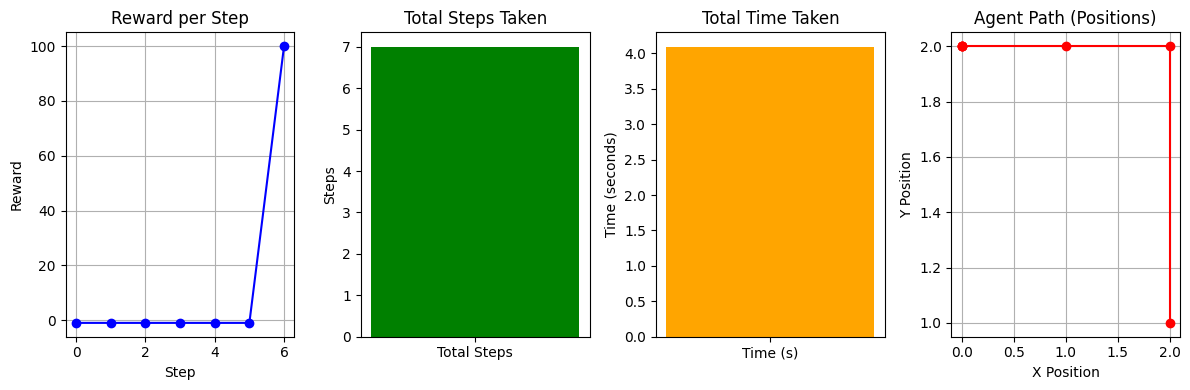

In [39]:
import matplotlib.pyplot as plt
import time

# Function to test the trained agent and collect data, including time
def test_agent(env, model, max_steps=100):
    obs = env.reset()
    total_reward = 0
    positions = []  # To track the positions of the agent
    rewards = []    # To track the rewards obtained
    steps = 0       # To track the number of steps taken

    # Start time measurement
    start_time = time.time()

    for i in range(max_steps):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        # Track the position, reward, and step count
        positions.append(env.current_pos)
        rewards.append(reward)
        total_reward += reward
        steps += 1

        env.render()  # Visualize the environment during testing

        if done:
            print("Goal reached!")
            break

    # End time measurement
    end_time = time.time()

    # Calculate total time taken
    total_time = end_time - start_time

    return total_reward, steps, positions, rewards, total_time

# Visualize the results after testing, including time
def visualize_results(total_reward, steps, positions, rewards, total_time):
    # Plot the total reward during testing
    plt.figure(figsize=(12, 4))

    # 1. Reward plot
    plt.subplot(1, 4, 1)
    plt.plot(range(len(rewards)), rewards, marker='o', color='b')
    plt.title('Reward per Step')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.grid(True)

    # 2. Steps plot
    plt.subplot(1, 4, 2)
    plt.bar(['Total Steps'], [steps], color='g')
    plt.title('Total Steps Taken')
    plt.ylabel('Steps')

    # 3. Time plot
    plt.subplot(1, 4, 3)
    plt.bar(['Time (s)'], [total_time], color='orange')
    plt.title('Total Time Taken')
    plt.ylabel('Time (seconds)')

    # 4. Path plot (Agent’s positions on the grid)
    plt.subplot(1, 4, 4)
    x_positions = [pos[1] for pos in positions]  # Extract X coordinates
    y_positions = [pos[0] for pos in positions]  # Extract Y coordinates
    plt.plot(x_positions, y_positions, marker='o', color='r')
    plt.title('Agent Path (Positions)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(True)

    # Display all plots
    plt.tight_layout()
    plt.show()

# Initialize the environment and load the trained model
env = WarehouseEnv(rows=5, cols=5, num_obstacles=5)
 # Load the previously trained model

# Test the agent and collect data including time
total_reward, steps, positions, rewards, total_time = test_agent(env, model)

# Visualize the results including time
visualize_results(total_reward, steps, positions, rewards, total_time)
